# Machine learning approaches to find features in zebrafish images

Load modules

In [1]:
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit
# ML
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical
import pandas as pd

C:\Users\me\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load plotting related stylesheets

In [2]:
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (3, 2)

Load and prepare data for NN

In [3]:
folder = r''
path_to_a_fish = r''

heads = np.array([cv2.imread(i,0) for i in glob(folder+'\\head\\*.png')])
tip = np.array([cv2.imread(i,0) for i in glob(folder+'\\tailtip\\*.png')])
base = np.array([cv2.imread(i,0) for i in glob(folder+'\\tailbase\\*.png')])
bg = np.array([cv2.imread(i,0) for i in glob(folder+'\\background\\*.png')])
labels = ['head','tail tip', 'tail base', 'background']

input_shape = heads.shape[1]

X = np.vstack([heads, tip, base, bg])
X = X / X.max(0)[None] # convert to float and normalize image from 0 to 1.
Y = np.repeat([0, 1, 2, 3],450,0)

Split train and test dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
n_epochs = 10

Train a neuron network that consist of
- a full connected layer
- a dense, hidden layer with 32 neurons
- an output layer with 4 neurons comprising the four categories _head_, _tail base_, _tail tip_ and _background_

In [6]:
model = Sequential()

model.add(Dense(units=32, activation='relu', input_dim=80*80))
model.add(Dense(units=4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

r = model.fit(X_train.reshape(X_train.shape[0],-1), 
          to_categorical(y_train,4), 
          batch_size=32, 
          epochs=n_epochs, 
          validation_split=0.05)

Train on 1368 samples, validate on 72 samples
Epoch 1/10
1368/1368 [==============================] - 0s 251us/step - loss: 0.5710 - acc: 0.7558 - val_loss: 0.3508 - val_acc: 0.9722
Epoch 2/10
1368/1368 [==============================] - 0s 158us/step - loss: 0.2445 - acc: 0.9313 - val_loss: 0.2425 - val_acc: 0.9722
Epoch 3/10
1368/1368 [==============================] - 0s 163us/step - loss: 0.1869 - acc: 0.9561 - val_loss: 0.1981 - val_acc: 0.9722
Epoch 4/10
1368/1368 [==============================] - 0s 135us/step - loss: 0.1403 - acc: 0.9803 - val_loss: 0.1757 - val_acc: 0.9722
Epoch 5/10
1368/1368 [==============================] - 0s 141us/step - loss: 0.1264 - acc: 0.9737 - val_loss: 0.1579 - val_acc: 0.9722
Epoch 6/10
1368/1368 [==============================] - 0s 155us/step - loss: 0.1091 - acc: 0.9781 - val_loss: 0.1878 - val_acc: 0.9306
Epoch 7/10
1368/1368 [==============================] - 0s 146us/step - loss: 0.1088 - acc: 0.9788 - val_loss: 0.1401 - val_acc: 0.9722
Ep

Plot the accuracy of the neural network evolved per epoch

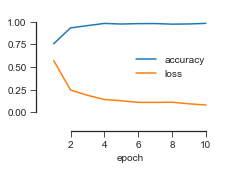

In [7]:
plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['loss'], label='loss')
plt.xlabel('epoch')
plt.xticks(np.arange(n_epochs)[1::2], np.arange(n_epochs)[1::2]+1)
plt.legend(loc='best')
plt.ylim([-.1, 1.1])
sns.despine(trim=True, offset=10)

Plot the probability of each test image per category

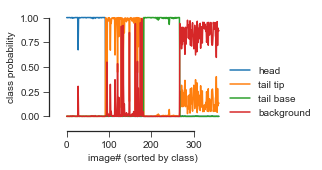

In [8]:
plt.plot(model.predict(X_test.reshape(X_test.shape[0],-1))[np.argsort(y_test)])
sns.despine(trim=True, offset=10)
plt.xlabel('image# (sorted by class)')
plt.ylabel('class probability')
plt.legend(labels, loc=[1, 0])

Predict the class of each test image (ordered by category). 

Note the spikes that indicate that some images are misclassified as background being actual tail tips.

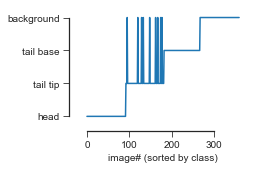

In [9]:
plt.plot(model.predict_classes(X_test.reshape(X_test.shape[0],-1)[np.argsort(y_test)]))
sns.despine(trim=True, offset=10)
plt.yticks(range(4), labels)
plt.xlabel('image# (sorted by class)')

Predict the NN response px-wise in a zebrafish image

In [10]:
fish = cv2.imread(path_to_a_fish, 0)

Downsample the image by a given factor

In [11]:
sample_step = 2

In [12]:
@jit
def subsample_px_from_im(im, input_shape=80, step=2):
    range_x = np.arange(input_shape//2, im.shape[0]-input_shape//2, step)
    range_y = np.arange(input_shape//2, im.shape[1]-input_shape//2, step)
    pred_im = np.zeros((range_x.shape[0], range_y.shape[0], input_shape*input_shape), dtype=np.float16)
    
    for i, x in enumerate(range_x):
        for j, y in enumerate(range_y):
            pred_im[i,j] = im[x-input_shape//2:x+input_shape//2, y-input_shape//2:y+input_shape//2].flatten()
            
    return pred_im      

Subsample image and prepare data for NN. Predict for each px the NN response.

In [13]:
%time subim = subsample_px_from_im(fish/255, step=sample_step)
%time pred = model.predict(subim.reshape((-1, input_shape*input_shape)))

Wall time: 2.8 s
Wall time: 2.41 s


Plot the predicted class probabilty per class

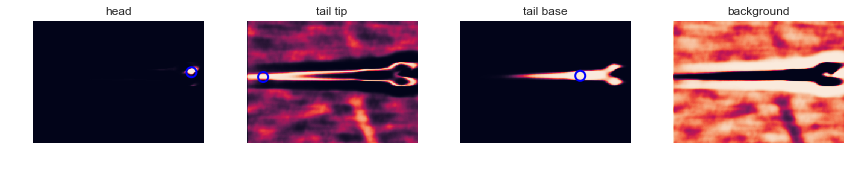

In [14]:
peaks = []

plt.figure(figsize=(12,3))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(pred.reshape((*subim.shape[:2], -1))[...,i], vmin=0, vmax=1)
    plt.axis('off')
    #plt.colorbar(fraction=.03)
    plt.title(labels[i])
    
    # Show peaks for the three foreground features
    if i < 3:
        peak = np.unravel_index(np.argmax(pred[...,i]), subim.shape[:2])
        plt.scatter(*peak[::-1], s=100, alpha=1, color='b', lw=2, marker='o', facecolor='none')
        peaks.append(np.array(peak)*sample_step+input_shape//2)
        
plt.tight_layout()

## Display features at fish

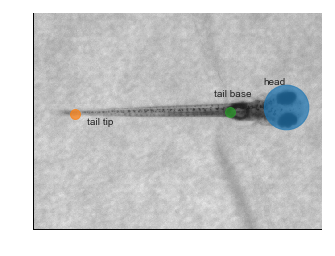

In [15]:
plt.figure(figsize=(6,4))
plt.imshow(fish, cmap='gray') #[4:-4, 4:-4]

plt.scatter(*peaks[0][::-1], s=2000, alpha=.7)
plt.text(*(peaks[0][::-1]-50), 'head')

plt.scatter(*peaks[1][::-1], s=100, alpha=.7)
plt.text(*(peaks[1][::-1]+25), 'tail tip')

plt.scatter(*peaks[2][::-1], s=100, alpha=.7)
plt.text(*(peaks[2][::-1]-35), 'tail base')

plt.axis('off')

# Show effect of neurons in first hidden layer on accuracy

In [25]:
all_acc = []
acc_course = []
n_neurons_1st_layer = [4, 8, 12, 16, 32, 48, 64, 128]
n_epochs = [5, 10, 20, 40]

for _n_epochs in n_epochs:
    acc = []
    
    for _n_neurons_1st_layer in n_neurons_1st_layer:
        model = Sequential()

        model.add(Dense(units=_n_neurons_1st_layer, activation='relu', input_dim=80*80))
        model.add(Dense(units=4, activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        r = model.fit(X_train.reshape(X_train.shape[0],-1), 
                  to_categorical(y_train,4), 
                  batch_size=32, 
                  epochs=_n_epochs, 
                  validation_split=0.05)

        acc.append(r.history['acc'])
        
    all_acc.append([i[-1] for i in acc])
    acc_course.append(acc)

Train on 1368 samples, validate on 72 samples
Epoch 1/5
1368/1368 [==============================] - 1s 599us/step - loss: 0.9648 - acc: 0.5936 - val_loss: 0.7513 - val_acc: 0.6111
Epoch 2/5
1368/1368 [==============================] - 0s 99us/step - loss: 0.6863 - acc: 0.7069 - val_loss: 0.7043 - val_acc: 0.5833
Epoch 3/5
1368/1368 [==============================] - 0s 104us/step - loss: 0.6432 - acc: 0.7434 - val_loss: 0.6651 - val_acc: 0.6944
Epoch 4/5
1368/1368 [==============================] - 0s 105us/step - loss: 0.6159 - acc: 0.7836 - val_loss: 0.6426 - val_acc: 0.8333
Epoch 5/5
1368/1368 [==============================] - 0s 108us/step - loss: 0.5902 - acc: 0.7953 - val_loss: 0.6187 - val_acc: 0.8750
Train on 1368 samples, validate on 72 samples
Epoch 1/5
1368/1368 [==============================] - 1s 645us/step - loss: 0.9139 - acc: 0.6703 - val_loss: 0.6905 - val_acc: 0.8750
Epoch 2/5
1368/1368 [==============================] - 0s 112us/step - loss: 0.6267 - acc: 0.8830 -

1368/1368 [==============================] - 0s 110us/step - loss: 1.3864 - acc: 0.2537 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 9/10
1368/1368 [==============================] - 0s 110us/step - loss: 1.3863 - acc: 0.2537 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 10/10
1368/1368 [==============================] - 0s 119us/step - loss: 1.3863 - acc: 0.2537 - val_loss: 1.3865 - val_acc: 0.2500
Train on 1368 samples, validate on 72 samples
Epoch 1/10
1368/1368 [==============================] - 1s 771us/step - loss: 0.7549 - acc: 0.6279 - val_loss: 0.4982 - val_acc: 0.6667
Epoch 2/10
1368/1368 [==============================] - 0s 124us/step - loss: 0.4073 - acc: 0.8041 - val_loss: 0.3841 - val_acc: 0.9306
Epoch 3/10
1368/1368 [==============================] - 0s 123us/step - loss: 0.3468 - acc: 0.8304 - val_loss: 0.3274 - val_acc: 0.8889
Epoch 4/10
1368/1368 [==============================] - 0s 128us/step - loss: 0.2833 - acc: 0.8816 - val_loss: 0.3243 - val_acc: 0.8889
Epoch 5/10
1

1368/1368 [==============================] - 1s 547us/step - loss: 0.0942 - acc: 0.9788 - val_loss: 0.1820 - val_acc: 0.9583
Epoch 7/10
1368/1368 [==============================] - 1s 566us/step - loss: 0.0967 - acc: 0.9759 - val_loss: 0.1305 - val_acc: 0.9722
Epoch 8/10
1368/1368 [==============================] - 1s 528us/step - loss: 0.0982 - acc: 0.9722 - val_loss: 0.1285 - val_acc: 0.9722
Epoch 9/10
1368/1368 [==============================] - 1s 565us/step - loss: 0.0736 - acc: 0.9817 - val_loss: 0.1380 - val_acc: 0.9722
Epoch 10/10
1368/1368 [==============================] - 1s 560us/step - loss: 0.0780 - acc: 0.9803 - val_loss: 0.1300 - val_acc: 0.9722
Train on 1368 samples, validate on 72 samples
Epoch 1/20
1368/1368 [==============================] - 1s 849us/step - loss: 1.4067 - acc: 0.2376 - val_loss: 1.3863 - val_acc: 0.2222
Epoch 2/20
1368/1368 [==============================] - 0s 111us/step - loss: 1.3864 - acc: 0.2383 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 3/20
1

1368/1368 [==============================] - 0s 139us/step - loss: 0.3488 - acc: 0.7873 - val_loss: 0.3656 - val_acc: 0.8056
Epoch 16/20
1368/1368 [==============================] - 0s 145us/step - loss: 0.3446 - acc: 0.7968 - val_loss: 0.3641 - val_acc: 0.7639
Epoch 17/20
1368/1368 [==============================] - 0s 150us/step - loss: 0.3399 - acc: 0.8187 - val_loss: 0.3691 - val_acc: 0.7361
Epoch 18/20
1368/1368 [==============================] - 0s 156us/step - loss: 0.3424 - acc: 0.7924 - val_loss: 0.3539 - val_acc: 0.8611
Epoch 19/20
1368/1368 [==============================] - 0s 153us/step - loss: 0.3289 - acc: 0.8596 - val_loss: 0.3653 - val_acc: 0.8194
Epoch 20/20
1368/1368 [==============================] - 0s 148us/step - loss: 0.3291 - acc: 0.8465 - val_loss: 0.3435 - val_acc: 0.8750
Train on 1368 samples, validate on 72 samples
Epoch 1/20
1368/1368 [==============================] - 1s 900us/step - loss: 0.6871 - acc: 0.7259 - val_loss: 0.3454 - val_acc: 0.9583
Epoch 2/

1368/1368 [==============================] - 0s 292us/step - loss: 0.0687 - acc: 0.9846 - val_loss: 0.1393 - val_acc: 0.9722
Epoch 15/20
1368/1368 [==============================] - 0s 282us/step - loss: 0.0781 - acc: 0.9817 - val_loss: 0.1165 - val_acc: 0.9722
Epoch 16/20
1368/1368 [==============================] - 0s 280us/step - loss: 0.0683 - acc: 0.9839 - val_loss: 0.2233 - val_acc: 0.9167
Epoch 17/20
1368/1368 [==============================] - 0s 283us/step - loss: 0.0826 - acc: 0.9773 - val_loss: 0.1243 - val_acc: 0.9722
Epoch 18/20
1368/1368 [==============================] - 0s 278us/step - loss: 0.0779 - acc: 0.9810 - val_loss: 0.1148 - val_acc: 0.9722
Epoch 19/20
1368/1368 [==============================] - 0s 281us/step - loss: 0.0640 - acc: 0.9854 - val_loss: 0.1564 - val_acc: 0.9722
Epoch 20/20
1368/1368 [==============================] - 0s 297us/step - loss: 0.0845 - acc: 0.9744 - val_loss: 0.1668 - val_acc: 0.9722
Train on 1368 samples, validate on 72 samples
Epoch 1

1368/1368 [==============================] - 0s 112us/step - loss: 0.8945 - acc: 0.5000 - val_loss: 0.8806 - val_acc: 0.4861
Epoch 14/40
1368/1368 [==============================] - 0s 110us/step - loss: 0.8836 - acc: 0.5015 - val_loss: 0.8731 - val_acc: 0.4722
Epoch 15/40
1368/1368 [==============================] - 0s 111us/step - loss: 0.8746 - acc: 0.4993 - val_loss: 0.8618 - val_acc: 0.4722
Epoch 16/40
1368/1368 [==============================] - 0s 116us/step - loss: 0.8651 - acc: 0.4971 - val_loss: 0.8524 - val_acc: 0.4861
Epoch 17/40
1368/1368 [==============================] - 0s 112us/step - loss: 0.8572 - acc: 0.5029 - val_loss: 0.8470 - val_acc: 0.4722
Epoch 18/40
1368/1368 [==============================] - 0s 112us/step - loss: 0.8494 - acc: 0.4971 - val_loss: 0.8411 - val_acc: 0.4722
Epoch 19/40
1368/1368 [==============================] - 0s 109us/step - loss: 0.8416 - acc: 0.5029 - val_loss: 0.8316 - val_acc: 0.4722
Epoch 20/40
1368/1368 [==============================

1368/1368 [==============================] - 0s 123us/step - loss: 1.3864 - acc: 0.2537 - val_loss: 1.3866 - val_acc: 0.2500
Epoch 33/40
1368/1368 [==============================] - 0s 120us/step - loss: 1.3864 - acc: 0.2537 - val_loss: 1.3865 - val_acc: 0.2500
Epoch 34/40
1368/1368 [==============================] - 0s 123us/step - loss: 1.3864 - acc: 0.2537 - val_loss: 1.3866 - val_acc: 0.2500
Epoch 35/40
1368/1368 [==============================] - 0s 119us/step - loss: 1.3864 - acc: 0.2537 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 36/40
1368/1368 [==============================] - 0s 118us/step - loss: 1.3863 - acc: 0.2537 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 37/40
1368/1368 [==============================] - 0s 118us/step - loss: 1.3863 - acc: 0.2537 - val_loss: 1.3864 - val_acc: 0.2500
Epoch 38/40
1368/1368 [==============================] - 0s 118us/step - loss: 1.3863 - acc: 0.2537 - val_loss: 1.3865 - val_acc: 0.2500
Epoch 39/40
1368/1368 [==============================

1368/1368 [==============================] - 0s 157us/step - loss: 0.2961 - acc: 0.9079 - val_loss: 0.3266 - val_acc: 0.7500
Epoch 12/40
1368/1368 [==============================] - 0s 152us/step - loss: 0.2738 - acc: 0.9225 - val_loss: 0.2995 - val_acc: 0.8056
Epoch 13/40
1368/1368 [==============================] - 0s 159us/step - loss: 0.2510 - acc: 0.9327 - val_loss: 0.2665 - val_acc: 0.9722
Epoch 14/40
1368/1368 [==============================] - 0s 155us/step - loss: 0.2312 - acc: 0.9342 - val_loss: 0.2505 - val_acc: 0.9583
Epoch 15/40
1368/1368 [==============================] - 0s 155us/step - loss: 0.2056 - acc: 0.9613 - val_loss: 0.2254 - val_acc: 0.9722
Epoch 16/40
1368/1368 [==============================] - 0s 157us/step - loss: 0.1837 - acc: 0.9642 - val_loss: 0.2151 - val_acc: 0.9583
Epoch 17/40
1368/1368 [==============================] - 0s 160us/step - loss: 0.1670 - acc: 0.9708 - val_loss: 0.1984 - val_acc: 0.9722
Epoch 18/40
1368/1368 [==============================

1368/1368 [==============================] - 0s 238us/step - loss: 0.0589 - acc: 0.9825 - val_loss: 0.1167 - val_acc: 0.9861
Epoch 31/40
1368/1368 [==============================] - 0s 232us/step - loss: 0.0524 - acc: 0.9890 - val_loss: 0.1156 - val_acc: 0.9861
Epoch 32/40
1368/1368 [==============================] - 0s 236us/step - loss: 0.1174 - acc: 0.9561 - val_loss: 0.1249 - val_acc: 0.9861
Epoch 33/40
1368/1368 [==============================] - 0s 224us/step - loss: 0.0547 - acc: 0.9854 - val_loss: 0.1393 - val_acc: 0.9722
Epoch 34/40
1368/1368 [==============================] - 0s 234us/step - loss: 0.0818 - acc: 0.9737 - val_loss: 0.1338 - val_acc: 0.9722
Epoch 35/40
1368/1368 [==============================] - 0s 214us/step - loss: 0.0544 - acc: 0.9832 - val_loss: 0.1197 - val_acc: 0.9861
Epoch 36/40
1368/1368 [==============================] - 0s 222us/step - loss: 0.0567 - acc: 0.9876 - val_loss: 0.1280 - val_acc: 0.9722
Epoch 37/40
1368/1368 [==============================

1368/1368 [==============================] - 1s 400us/step - loss: 0.1028 - acc: 0.9810 - val_loss: 0.1531 - val_acc: 0.9722
Epoch 10/40
1368/1368 [==============================] - 1s 418us/step - loss: 0.0949 - acc: 0.9751 - val_loss: 0.1603 - val_acc: 0.9722
Epoch 11/40
1368/1368 [==============================] - 1s 397us/step - loss: 0.1109 - acc: 0.9678 - val_loss: 0.1283 - val_acc: 0.9722
Epoch 12/40
1368/1368 [==============================] - 0s 356us/step - loss: 0.0813 - acc: 0.9825 - val_loss: 0.1288 - val_acc: 0.9722
Epoch 13/40
1368/1368 [==============================] - 0s 357us/step - loss: 0.0804 - acc: 0.9832 - val_loss: 0.1233 - val_acc: 0.9722
Epoch 14/40
1368/1368 [==============================] - 1s 369us/step - loss: 0.1033 - acc: 0.9693 - val_loss: 0.2300 - val_acc: 0.9167
Epoch 15/40
1368/1368 [==============================] - 1s 408us/step - loss: 0.0893 - acc: 0.9715 - val_loss: 0.1262 - val_acc: 0.9861
Epoch 16/40
1368/1368 [==============================

1368/1368 [==============================] - 1s 512us/step - loss: 0.0539 - acc: 0.9861 - val_loss: 0.1358 - val_acc: 0.9722
Epoch 29/40
1368/1368 [==============================] - 1s 539us/step - loss: 0.0436 - acc: 0.9898 - val_loss: 0.1266 - val_acc: 0.9861
Epoch 30/40
1368/1368 [==============================] - 1s 500us/step - loss: 0.0591 - acc: 0.9876 - val_loss: 0.1308 - val_acc: 0.9861
Epoch 31/40
1368/1368 [==============================] - 1s 478us/step - loss: 0.0485 - acc: 0.9883 - val_loss: 0.1222 - val_acc: 0.9861
Epoch 32/40
1368/1368 [==============================] - 1s 494us/step - loss: 0.0736 - acc: 0.9759 - val_loss: 0.1220 - val_acc: 0.9861
Epoch 33/40
1368/1368 [==============================] - 1s 476us/step - loss: 0.0644 - acc: 0.9817 - val_loss: 0.1269 - val_acc: 0.9861
Epoch 34/40
1368/1368 [==============================] - 1s 491us/step - loss: 0.0505 - acc: 0.9868 - val_loss: 0.1367 - val_acc: 0.9861
Epoch 35/40
1368/1368 [==============================

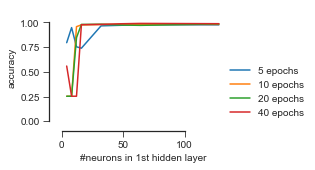

In [26]:
plt.figure(figsize=(3,2))
for e in range(len(n_epochs)): 
    plt.plot(n_neurons_1st_layer, all_acc[e], label='{} epochs'.format(n_epochs[e]))
plt.ylim([0,1.1])
plt.legend(loc=[1,0])
plt.xlabel('#neurons in 1st hidden layer')
plt.ylabel('accuracy')

sns.despine(trim=True, offset=10)

## Show the effect of # of neurons and epochs on accuracy

In [27]:
df = pd.DataFrame([pd.Series(v) for v in acc_course[2]]).T

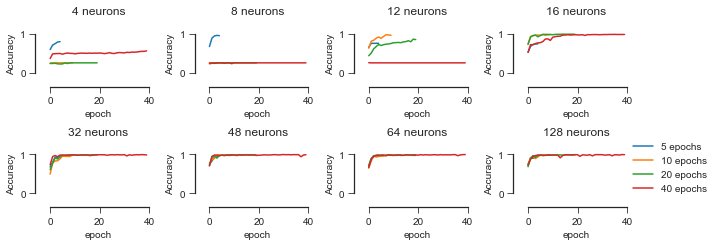

In [28]:
plt.figure(figsize=(9, 3.5))

for ni, neurons in enumerate(n_neurons_1st_layer):
    if ni == 0:
        ax = plt.subplot(2,4,ni+1)
    else:
        plt.subplot(2,4,ni+1, sharey=ax)
    
    for i in range(len(acc_course)):
        df = pd.DataFrame([pd.Series(v) for v in acc_course[i]]).T
        plt.plot(df[ni])
    
    plt.title('{} neurons'.format(neurons), y=1.2)
    plt.ylim([-.1,1.1])
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    
plt.legend(['{} epochs'.format(i) for i in [5,10,20,40]], loc=[1,0])
plt.tight_layout()
sns.despine(trim=True, offset=10)

# Use the data in convolutional neural network

In [20]:
n_epochs = 10

conv_model = Sequential()
conv_model.add(Conv2D(32, kernel_size=(4, 4), input_shape=(80,80,1), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
#conv_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(32, activation='relu'))
conv_model.add(Dense(units=4, activation='softmax'))

conv_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

r = conv_model.fit(X_train[...,None], 
          to_categorical(y_train,4), 
          batch_size=32, 
          epochs=n_epochs, 
          validation_split=0.05)

Train on 1368 samples, validate on 72 samples
Epoch 1/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.5912 - acc: 0.7193 - val_loss: 0.3189 - val_acc: 0.9306
Epoch 2/10
1368/1368 [==============================] - 5s 3ms/step - loss: 0.2349 - acc: 0.9072 - val_loss: 0.1748 - val_acc: 0.9722
Epoch 3/10
1368/1368 [==============================] - 5s 3ms/step - loss: 0.1307 - acc: 0.9649 - val_loss: 0.1451 - val_acc: 0.9583
Epoch 4/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.0856 - acc: 0.9773 - val_loss: 0.1421 - val_acc: 0.9861
Epoch 5/10
1368/1368 [==============================] - 5s 3ms/step - loss: 0.1081 - acc: 0.9620 - val_loss: 0.1650 - val_acc: 0.9167
Epoch 6/10
1368/1368 [==============================] - 4s 3ms/step - loss: 0.0929 - acc: 0.9773 - val_loss: 0.2601 - val_acc: 0.9028
Epoch 7/10
1368/1368 [==============================] - 4s 3ms/step - loss: 0.0933 - acc: 0.9686 - val_loss: 0.1061 - val_acc: 0.9722
Epoch 8/10
1368/

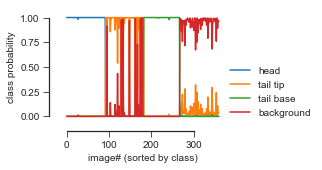

In [21]:
plt.plot(conv_model.predict(X_test[np.argsort(y_test)][...,None]))
sns.despine(trim=True, offset=10)
plt.xlabel('image# (sorted by class)')
plt.ylabel('class probability')
plt.legend(['head','tail tip', 'tail base', 'background'], loc=[1, 0])

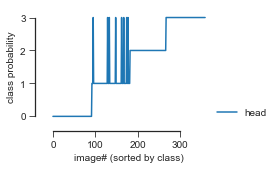

In [22]:
plt.plot(conv_model.predict_classes(X_test[np.argsort(y_test)][...,None]))
sns.despine(trim=True, offset=10)
plt.xlabel('image# (sorted by class)')
plt.ylabel('class probability')
plt.legend(['head','tail tip', 'tail base', 'background'], loc=[1, 0])

In [23]:
%time subim = subsample_px_from_im(fish/255, step=sample_step)
%time pred = conv_model.predict(subim.reshape(-1, 80, 80, 1))

Wall time: 2.29 s
Wall time: 54.3 s


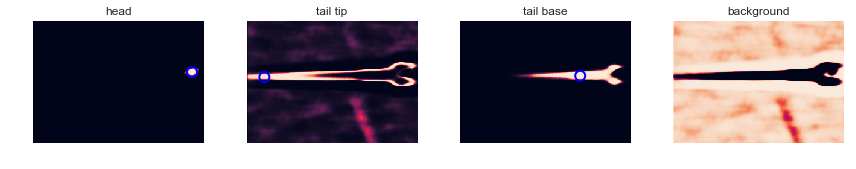

In [24]:
peaks = []

plt.figure(figsize=(12,3))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(pred.reshape((*subim.shape[:2], -1))[...,i], vmin=0, vmax=1)
    plt.axis('off')
    #plt.colorbar(fraction=.03)
    plt.title(labels[i])
    
    # Show peaks for the three foreground features
    if i < 3:
        peak = np.unravel_index(np.argmax(pred[...,i]), subim.shape[:2])
        plt.scatter(*peak[::-1], s=100, alpha=1, color='b', lw=2, marker='o', facecolor='none')
        peaks.append(np.array(peak)*sample_step+input_shape//2)
        
plt.tight_layout()